In [1]:
import gc
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import msmtools
import numpy as np
import prettypyplot as pplt
import pyemma
import seaborn as sns
import sklearn
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# distances to F161
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

lag = 500
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [5]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [7]:
sb_ids = [42, 47, 52, 53, 58, 59]
feat_arr = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))
print(feat_arr.shape)

(4150115, 9)


In [8]:
traj_inds = util.split_indices(cv_trajs)
feat_trajs = np.split(feat_arr, traj_inds)

# Distance basis

In [9]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
# sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    # & (sb5 < 0.6)
)

In [10]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [11]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   9136
Number of other structures: 4103127


In [12]:
random.seed(123)

In [13]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

## compute distance to states

In [14]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [16]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.09% completed
0.17% completed
0.26% completed
0.34% completed
0.43% completed
0.51% completed
0.60% completed
0.68% completed
0.77% completed
0.85% completed
0.94% completed
1.03% completed
1.11% completed
1.20% completed
1.28% completed
1.37% completed
1.45% completed
1.54% completed
1.62% completed
1.71% completed
1.79% completed
1.88% completed
1.96% completed
2.05% completed
2.14% completed
2.22% completed
2.31% completed
2.39% completed
2.48% completed
2.56% completed
2.65% completed
2.73% completed
2.82% completed
2.90% completed
2.99% completed
3.08% completed
3.16% completed
3.25% completed
3.33% completed
3.42% completed
3.50% completed
3.59% completed
3.67% completed
3.76% completed
3.84% completed
3.93% completed
4.01% completed
4.10% completed
4.19% completed
4.27% completed
4.36% completed
4.44% completed
4.53% completed
4.61% completed
4.70% completed
4.78% completed
4.87% completed
4.95% completed
5.04% completed
5.13% completed
5.21% completed
5.30% completed
5.38% co

In [17]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(4150115, 1)


In [18]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, up[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.35% completed
0.71% completed
1.06% completed
1.42% completed
1.77% completed
2.12% completed
2.48% completed
2.83% completed
3.19% completed
3.54% completed
3.89% completed
4.25% completed
4.60% completed
4.96% completed
5.31% completed
5.66% completed
6.02% completed
6.37% completed
6.73% completed
7.08% completed
7.43% completed
7.79% completed
8.14% completed
8.50% completed
8.85% completed
9.20% completed
9.56% completed
9.91% completed
10.27% completed
10.62% completed
10.97% completed
11.33% completed
11.68% completed
12.04% completed
12.39% completed
12.74% completed
13.10% completed
13.45% completed
13.81% completed
14.16% completed
14.51% completed
14.87% completed
15.22% completed
15.58% completed
15.93% completed
16.28% completed
16.64% completed
16.99% completed
17.35% completed
17.70% completed
18.05% completed
18.41% completed
18.76% completed
19.12% completed
19.47% completed
19.82% completed
20.18% completed
20.53% completed
20.89% completed
21.24% completed
21.59% c

In [19]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(4150115, 1)


In [20]:
np.save("../../data/feat_small_dist/dist_down", d_down_arr)
np.save("../../data/feat_small_dist/dist_up", d_up_arr)

## Basis and smoothing

In [21]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [22]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(4150115, 1) (4150115, 1) (4150115, 1)


## Basis and smoothing

In [23]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [24]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(4150115, 1) (4150115, 1) (4150115, 1)


In [26]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)

guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(guessU))
print(len(guessD))

352
352


In [27]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [28]:
# np.save("../../data/feat2_dist_du_anton2/weights_3.npy", weights)
# np.save("../../data/feat2_dist_du_anton2/weights_3_feat5ivac", weights)
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

In [30]:
basisF_arr = smooth * feat_arr
basisF = []
curr = 0
traj_lens = [len(t) for t in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

In [31]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [32]:
q_downup = []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basis_d, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000


/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


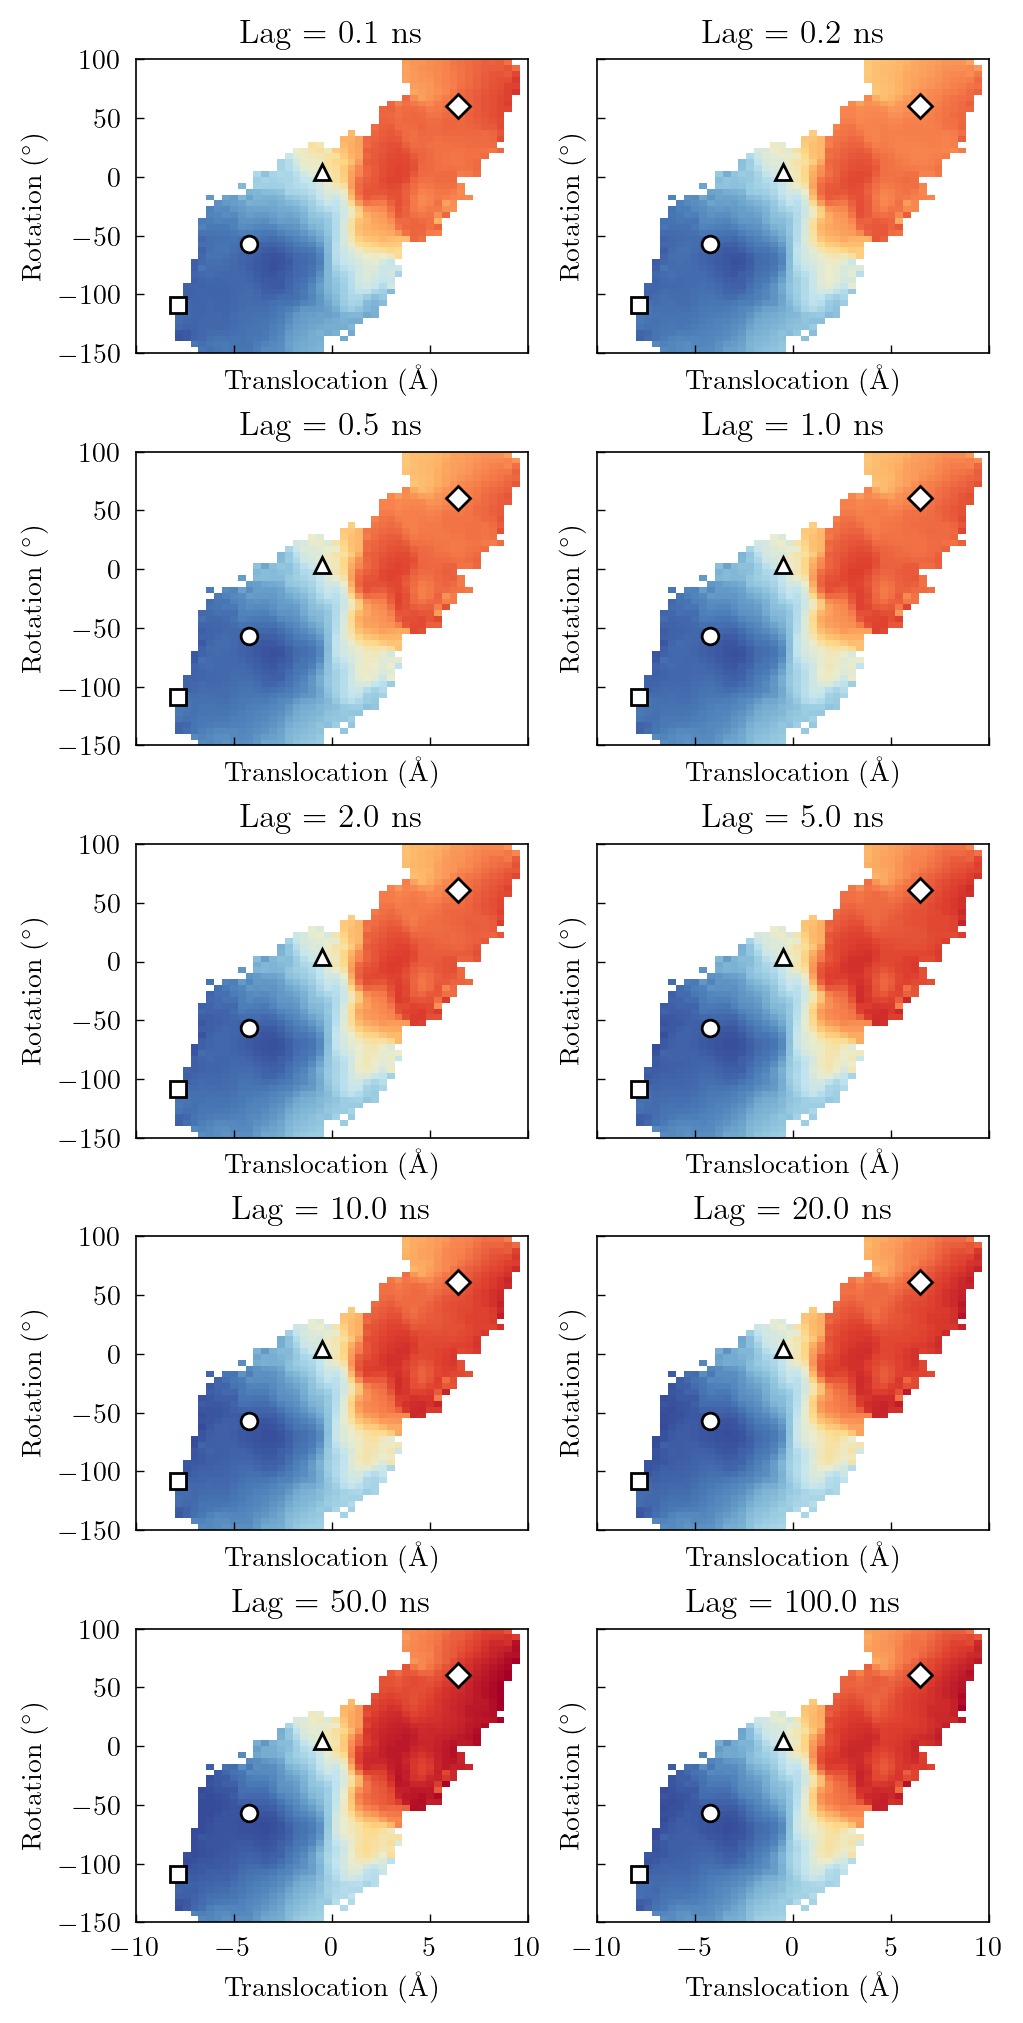

In [35]:
f, axs = plt.subplots(
    5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True
)
xe = np.linspace(-10, 10, 51)
ye = np.linspace(-150, 100, 51)
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_dens = extq.projection.average2d(
        dist_trajs, rot_trajs, q, weights[0], xe, ye
    )
    ax.pcolormesh(xe, ye, q_dens, cmap=cm_div, vmin=0, vmax=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True, ms=6)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


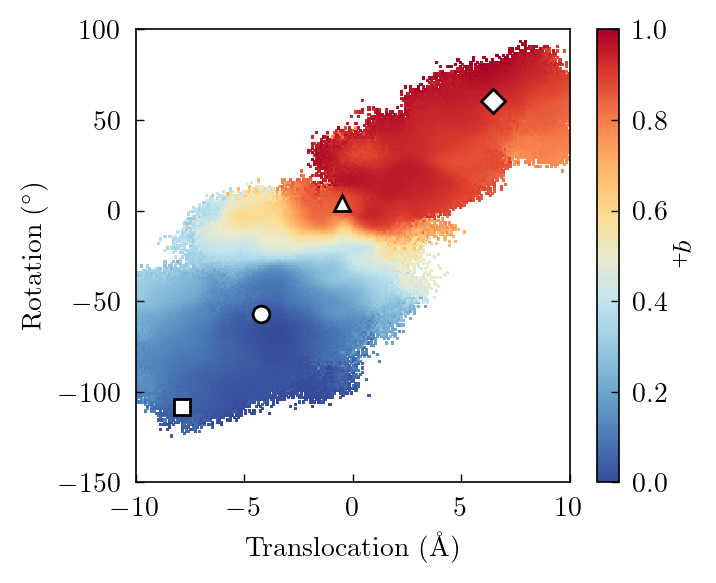

In [36]:
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
q_dens = extq.projection.average2d(
    dist_trajs, rot_trajs, q_downup[8], weights[0], xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

In [37]:
np.save("../../data/feat_small_dist/qp", q_downup)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [39]:
from extq.stop import forward_stop

In [42]:
# compute E[\theta(x) S_tq_+(x)]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights[0]]
qp_delay = []
for d, t in zip(in_domain, q_downup[8]):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

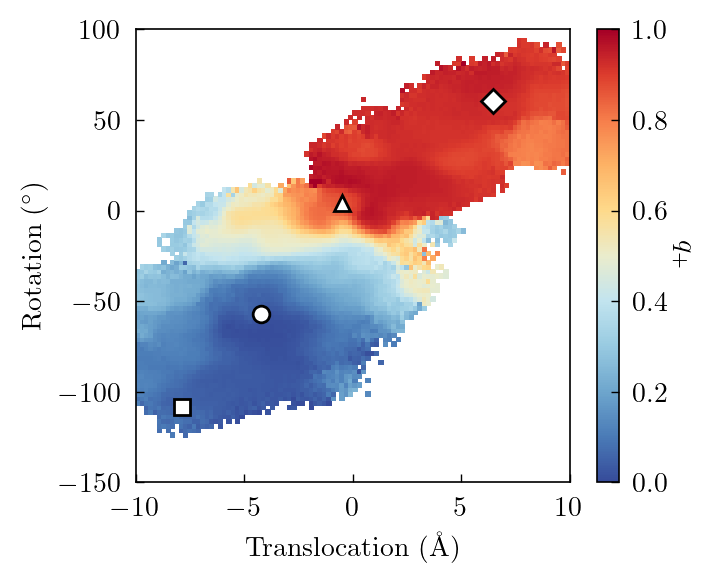

In [44]:
xe = np.linspace(-10, 10, 101)
ye = np.linspace(-150, 100, 101)
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

/scratch/local/jobs/4401190/ipykernel_2972653/2136576798.py:20: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f4559b779d0> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


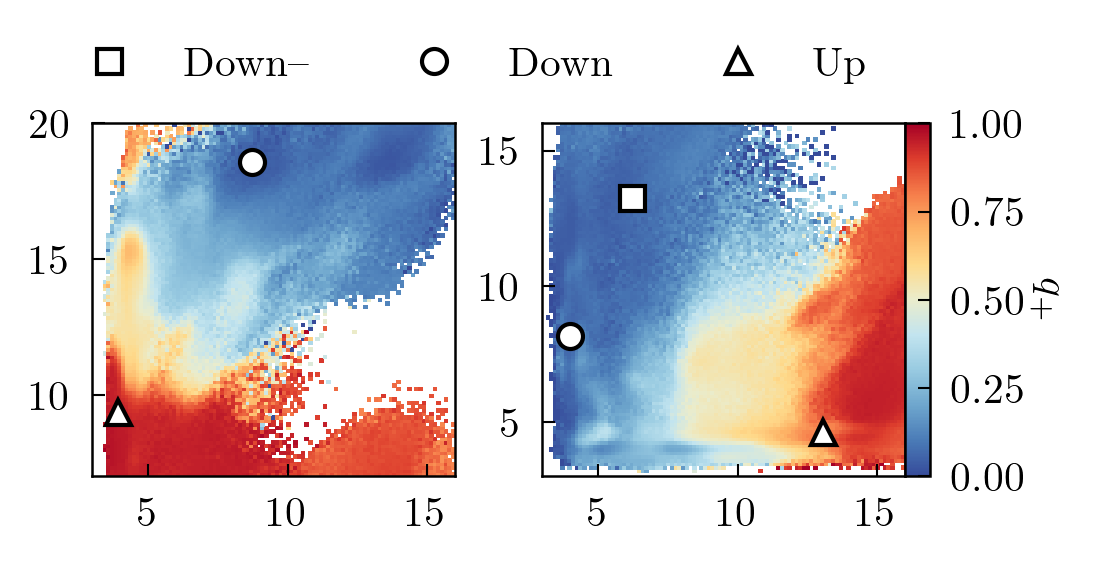

In [46]:
f, axes = plt.subplots(1, 2, figsize=(3.0, 1.5), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:-lag, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:-lag, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    q_dens = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_delay, w_delay, xlim, ylim)
    h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
    # ax.set(
    #     xlabel=f"{sb_names[sb1]} / Å",
    #     ylabel=f"{sb_names[sb2]} / Å",
    # )
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])
cb = pplt.colorbar(h)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

# Indicator basis

In [48]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [49]:
k = 500
std = StandardScaler()
feat_std = std.fit_transform(feat_arr)
km = MiniBatchKMeans(n_clusters=k)
km.fit(feat_std)

MiniBatchKMeans(n_clusters=500)

In [52]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)
dtrajs = neighbors.kneighbors(feat_std, return_distance=False)

In [53]:
np.save("../../data/feat_small_dist/dtrajs_500", dtrajs)

In [56]:
basis_sparse = util.make_dense_basis(np.squeeze(dtrajs))
basis_sparse[~mask] = 0

In [59]:
basis_ids = (np.sum(basis_sparse, axis=0) != 0)

In [62]:
from scipy import sparse

In [63]:
basis_d = np.split(basis_sparse, traj_inds)
basis_d_sparse = [sparse.csr_array(arr) for arr in basis_d]

In [64]:
basis_d = basis_d_sparse

In [74]:
qp_sparse = extq.dga.forward_committor(basis_d, com, in_domain, np.split(up_ids.astype(float), traj_inds), lag)

In [72]:
np.save("../../data/feat_small_dist/qp_ind.npy", qp_sparse)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [75]:
# compute E[\theta(x) S_tq_+(x)]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights[0]]
qp_delay = []
for d, t in zip(in_domain, qp_sparse):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


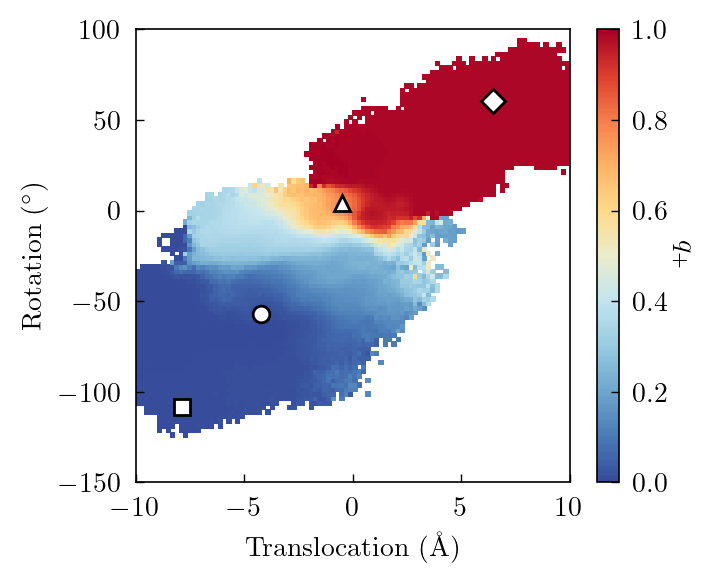

In [76]:
xe = np.linspace(-10, 10, 101)
ye = np.linspace(-150, 100, 101)
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

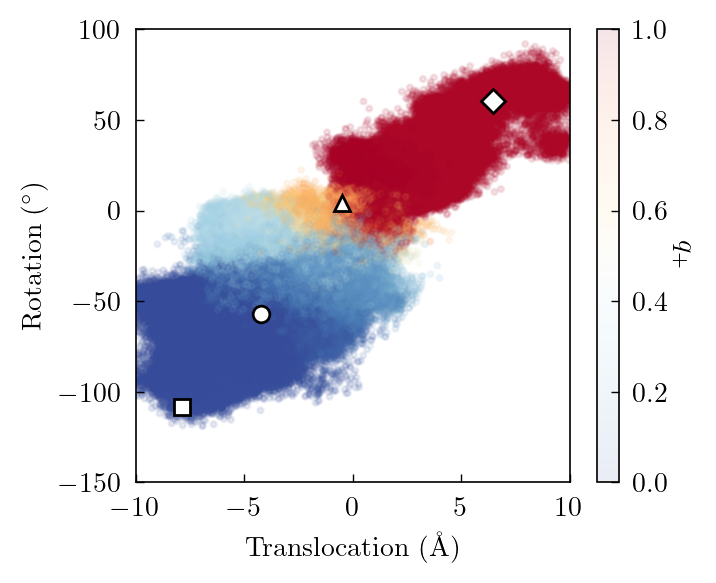

In [77]:
f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=np.concatenate(qp_sparse)[inds], cmap=cm_div, vmin=0, vmax=1, alpha=0.1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

/scratch/local/jobs/4401190/ipykernel_2972653/2136576798.py:20: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f4559ce8e80> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


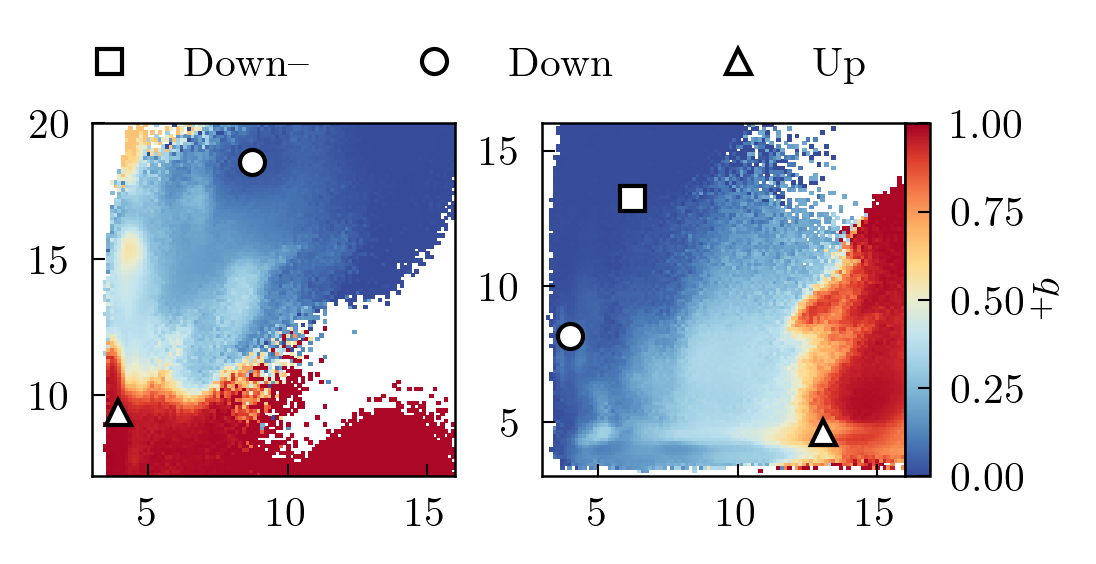

In [78]:
f, axes = plt.subplots(1, 2, figsize=(3.0, 1.5), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:-lag, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:-lag, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    q_dens = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_delay, w_delay, xlim, ylim)
    h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
    # ax.set(
    #     xlabel=f"{sb_names[sb1]} / Å",
    #     ylabel=f"{sb_names[sb2]} / Å",
    # )
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])
cb = pplt.colorbar(h)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

(array([ 569576.,  139601.,  249141.,  401454.,   87559.,   51399.,
         438860.,  270536.,  117259.,   32475.,   34848.,   38851.,
          31004.,  185307.,   53512.,   55089.,    4930.,   10359.,
          13505., 1364850.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

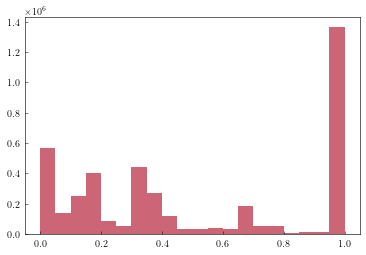

In [79]:
plt.hist(np.concatenate(qp_sparse), bins=20)